In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as skg
from scipy.special import erfc
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [2]:
f = lambda x: 1-2*x**2

In [3]:
lam = 1e-2
l = 0.5
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpa = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)
X = np.random.uniform(-1,1,3).reshape(-1,1).reshape(-1,1)
y = f(X)
gpa.fit(X,y)
gpa.kernel_.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=0.5),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': 'fixed',
 'k2__length_scale': 0.5,
 'k2__length_scale_bounds': 'fixed'}

In [4]:
xx = np.arange(-1,1,0.001)
mu_last, sigma_last = gpa.predict(xx.reshape(-1,1), return_std=True)
mu_last = mu_last.flatten()

Calculate raw $P_{err}$

In [5]:
p_err = 1/2*erfc(np.abs(mu_last)/sigma_last)

Calculate $\int_{-\infty}^\infty P_t^{err}(\phi,\phi_t)d\phi$

In [6]:
def gpa_next(gpa,x,y):

    g = skg.GaussianProcessRegressor(
        alpha=1e-2,
        kernel=kernel
    )
    g.fit(
        np.vstack((gpa.X_train_, np.array(x).reshape(-1,1))),
        np.vstack((gpa.y_train_, np.array(y).reshape(-1,1)))
    )
    # print(g.X_train_)
    return g

x_next_list = np.arange(-1,1,0.01)
util_exact = []

for x_next in x_next_list:

    y_next = gpa.predict(x_next.reshape(-1,1))
    g = gpa_next(
        gpa,
        x_next,
        y_next
        )
    m, s = g.predict(xx.reshape(-1,1), return_std=True)
    p_err_next = 1/2*erfc(np.abs(m)/s)
    util_exact.append(np.sum(p_err-p_err_next))

util_exact = np.array(util_exact)

Approximate $\int_{-\infty}^\infty \int_{-\infty}^\infty f(x_t) P_t^{err}(\phi,\phi_t)d\phi dx_t$ by assuming $P_t^{err}$ is locally linear

In [7]:
d = lambda a,b: np.linalg.norm(a-b)
k0 = lambda a,b: np.exp(-d(a,b)**2/2)

def kt1(gpa, x):
    xx = gpa.X_train_
    kt = [k0(x,x1) for x1 in xx]
    return np.array(kt).reshape(-1,1)

def Kt(gpa):
    xx = gpa.X_train_
    K = np.empty((3,3))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i,j] = k0(xx[i],xx[j])
    return K

def kt2(gpa, x1, x2):
    inv = np.linalg.pinv(Kt(gpa))
    m1 = np.dot(kt1(gpa,x1).transpose(), inv)
    return k0(x1,x2) - np.dot(np.dot(kt1(gpa,x1).transpose(), inv), kt1(gpa,x2))

def get_mu(gpa,x):
    return gpa.predict(np.array(x).reshape(-1,1))

def get_sigma(gpa,x):
    _,sigma = gpa.predict(np.array(x).reshape(-1,1), return_std=True)
    return sigma

print(get_mu(gpa,0))
print(get_sigma(gpa,0))

[[0.92056574]]
[0.27066276]


In [8]:
def mu_next(gpa, x, xt, yt):
    
    mu = get_mu(gpa,x)
    k = kt2(gpa,x,xt)
    var = get_sigma(gpa,x)**2
    
    return mu + k/(var+lam)*(yt-mu)

def sigma_next(gpa, x, xt):
    
    k = kt2(gpa,x,xt)
    var = get_sigma(gpa,x)**2
    
    return np.sqrt(lam*k/(lam+var))

def fdiff_1d(f,x0,h):
    
    x0 = np.array(x0)
    num = f(x0+h) - f(x0-h)
    return num/(2*h)


def fdiff_2d(f,x0,h):
    
    x0 = np.array(x0)
    num = f(x0+np.array([h,h])) - f(x0+np.array([h,-h])) - f(x0+np.array([-h,h])) + f(x0+np.array([-h,-h]))
    return num/(4*h**2)

def fdiff_3d(f,x0,h):
    
    x0 = np.array(x0)
    signs = np.array(np.meshgrid([-1,1], [-1,1], [-1,1])).T.reshape(-1,3)
    runsum = 0
    for s in signs:
        coeff = np.product(signs)
        runsum += coeff * f(x0+h*s)
    runsum = runsum / 8*h**3
    
    return runsum

In [9]:
def perr_next(gpa,x,xt,yt):
    
    g = gpa_next(gpa,xt,yt)
    return g.predict(np.array(x).reshape(-1,1))


x_next_list = np.arange(-1,1,0.01)
util_approx = []

for x_next in x_next_list:
    
    x0 = x_next
    y0 = gpa.predict(np.array(x0).reshape(-1,1)).flatten()[0]
    
    fxyz = lambda b: perr_next(gpa,b[0],b[1],b[2])
    d_xyz = fdiff_3d(fxyz,[x0,x0,y0],0.01)
    alpha_xyz = d_xyz
    
    fxz = lambda b: perr_next(gpa,b[0],b[1],y0)
    d_xz = fdiff_2d(fxz,[x0,x0],0.01).flatten()[0]
    alpha_xz = d_xz - alpha_xyz*y0
    
    fyz = lambda b: perr_next(gpa,b[0],x0,b[1])
    d_yz = fdiff_2d(fyz,[x0,y0],0.01).flatten()[0]
    alpha_yz = d_yz - alpha_xyz*x0  
    
    fz = lambda b: perr_next(gpa,b,x0,y0)
    d_z = fdiff_1d(fz,x0,0.01).flatten()[0]
    alpha_z = d_z - alpha_yz*y0 - alpha_xz*x0 - alpha_xyz*x0*y0
    
    
    util = alpha_z + (alpha_yz+alpha_xyz*x0)*y0 + alpha_xz*x0
    util = util.flatten()[0]
    
    util_approx.append(util)
    
util_approx = np.array(util_approx)

In [10]:
# x_next_list = np.arange(-1,1,0.01)
# util_approx = []

# def perr_next(gpa,x,xt,yt):
    
#     mu = mu_next(gpa,x,xt,yt)
#     sigma = sigma_next(gpa,x,xt)
    
#     return erfc(np.abs(mu)/sigma)/2

# for x_next in x_next_list:

#     y0 = gpa.predict(x_next.reshape(-1,1))
#     p1 = lambda b:  perr_next(gpa,b[0],b[1],y0)
#     ax = fdiff_2d(p1,[x_next,x_next],0.1)
#     # print(ax)
    
    
#     # m, s = g.predict(xx.reshape(-1,1), return_std=True)
#     # p_err_next = 1/2*erfc(np.abs(m)/s)
#     # util_exact.append(np.sum(p_err-p_err_next))

# util_exact = np.array(util_exact)

In [11]:
print(util_exact.shape)

(200,)


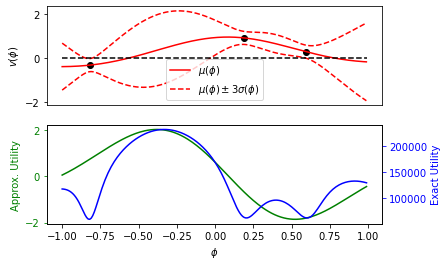

In [15]:
plt.subplot(2,1,1)
plt.plot(xx, mu_last, 'r')
plt.plot(xx,mu_last-3*sigma_last,'r--')
plt.plot(xx,mu_last+3*sigma_last,'r--')
plt.scatter(X,y,c='k')
plt.hlines(0,-1,1,'k','--')

plt.gca().set_xticks([], [])
plt.ylabel("$v(\phi)$")
plt.legend(["$\mu(\phi)$", "$\mu(\phi) \pm 3\sigma(\phi)$"])

#***

plt.subplot(2,1,2)
ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x_next_list, util_approx, 'g')
ax2.plot(x_next_list,util_exact, 'b')

ax.set_xlabel('$\phi$')
ax.set_ylabel('Approx. Utility')
ax.tick_params(axis='y', colors='g')
ax.yaxis.label.set_color('g')

ax2.set_ylabel('Exact Utility')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')


plt.savefig('linearized_utility_demo01.png')
plt.show()

In [13]:
gpa.kernel_.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=0.5),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': 'fixed',
 'k2__length_scale': 0.5,
 'k2__length_scale_bounds': 'fixed'}